## `Base-case`: 

Top-K RAG 

In [2]:
import weaviate
from langchain.vectorstores import Weaviate
from langchain.chat_models import ChatOpenAI
from langchain.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser
from langchain.embeddings.voyageai import VoyageEmbeddings
from langchain_core.runnables import RunnableLambda, RunnablePassthrough

# Keys
import os

WEAVIATE_URL = os.environ["WEAVIATE_URL"]
WEAVIATE_API_KEY = os.environ["WEAVIATE_API_KEY"]
WEAVIATE_DOCS_INDEX_NAME = "LangChain_agent_docs"


def get_embeddings_model():
    if os.environ.get("VOYAGE_API_KEY") and os.environ.get("VOYAGE_AI_MODEL"):
        return VoyageEmbeddings(model=os.environ["VOYAGE_AI_MODEL"])
    return OpenAIEmbeddings(chunk_size=200)


def get_retriever():
    weaviate_client = weaviate.Client(
        url=WEAVIATE_URL,
        auth_client_secret=weaviate.AuthApiKey(api_key=WEAVIATE_API_KEY),
    )
    weaviate_client = Weaviate(
        client=weaviate_client,
        index_name=WEAVIATE_DOCS_INDEX_NAME,
        text_key="text",
        embedding=get_embeddings_model(),
        by_text=False,
        attributes=["source", "title"],
    )
    return weaviate_client.as_retriever(search_kwargs=dict(k=6))


# Retriever
retriever = get_retriever()

# Prompt
template = """Answer the question based only on the following context:
{context}

Question: {question}
"""
prompt = ChatPromptTemplate.from_template(template)

# LLM
model = ChatOpenAI(model="gpt-4-1106-preview")

# Chain
base_rag_chain = (
    {"context": retriever, "question": RunnablePassthrough()}
    | prompt
    | model
    | StrOutputParser()
)

## `Context Stuffing`: 

Load contex related to LCEL.

In [4]:
from bs4 import BeautifulSoup as Soup
from langchain_community.document_loaders.recursive_url_loader import RecursiveUrlLoader

from langchain.chat_models import ChatOpenAI
from langchain.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser
from langchain_core.runnables import RunnableLambda, RunnablePassthrough

# Load LCEL docs
url = "https://python.langchain.com/docs/expression_language/"
loader = RecursiveUrlLoader(
    url=url, max_depth=20, extractor=lambda x: Soup(x, "html.parser").text
)
docs = loader.load()

# Sort the list based on the URLs in 'metadata' -> 'source'
d_sorted = sorted(docs, key=lambda x: x.metadata["source"])
d_reversed = list(reversed(d_sorted))

# Concatenate the 'page_content' of each sorted dictionary
concatenated_content = "\n\n\n --- \n\n\n".join(
    [doc.page_content for doc in d_reversed]
)

# Prompt template
template = """You are a coding assistant with expertise in LCEL, LangChain expression language. Here is a full set of documentation:
{context}

Now, answer the user question based on the above provided documentation: {question}
"""
prompt = ChatPromptTemplate.from_template(template)

model = ChatOpenAI(temperature=0, model="gpt-4-1106-preview")

long_context_chain = (
    {
        "context": lambda x: concatenated_content,
        "question": RunnablePassthrough(),
    }
    | prompt
    | model
    | StrOutputParser()
)

## `Query Expansion`: 

Sub-question / answer generation. 

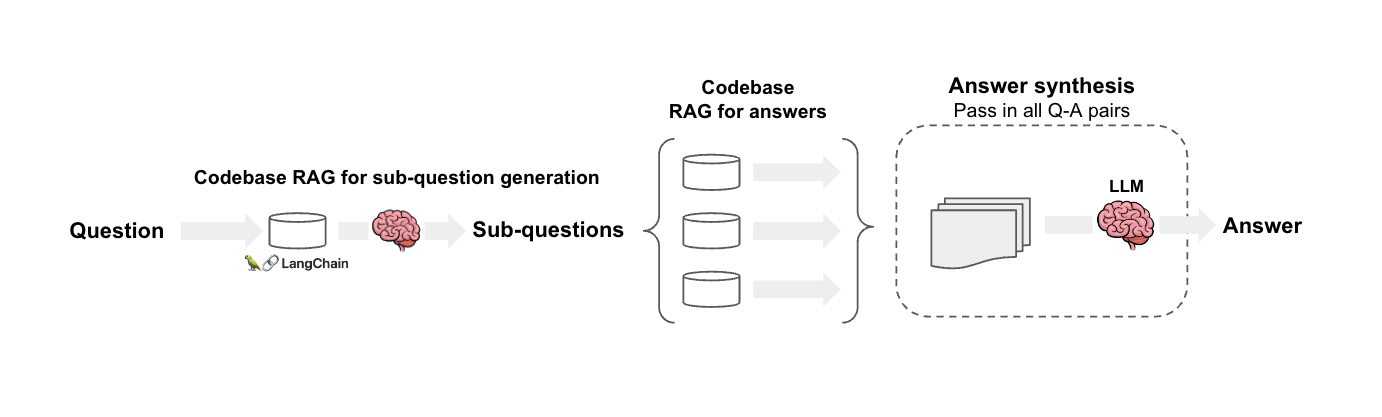

In [13]:
import sys

sys.path.append("..")
from app.chain import chain as code_langchain_chain

question = "how to chat PDF with chroma? Use LCEL"
answer = code_langchain_chain.invoke({"question": question})
answer

'Sure, here is a combined code snippet that demonstrates how to chat with a PDF using Chroma and LCEL in LangChain:\n\n```python\nfrom langchain.document_loaders import TextLoader\nfrom langchain.text_splitter import CharacterTextSplitter\nfrom langchain.embeddings.sentence_transformer import SentenceTransformerEmbeddings\nfrom langchain.vectorstores import Chroma\nfrom langchain.lcel import LCEL\n\n# Load the PDF document\nloader = TextLoader("path/to/your/pdf/file.pdf")\ndocument = loader.load()\n\n# Split the document into chunks\nsplitter = CharacterTextSplitter()\nchunks = splitter.split(document)\n\n# Create an embedding function\nembeddings = SentenceTransformerEmbeddings()\n\n# Initialize a Chroma vector store\nchroma = Chroma.from_documents(chunks, embeddings)\n\n# Initialize LCEL with Chroma\nlcel = LCEL(chroma)\n\n# Define the user\'s query\nquery = "What is the main topic of the PDF?"\n\n# Use LCEL to chat with the PDF\nresponse = lcel.chat(query)\n\n# Print the response\np

# Eval

Run eval, using `eval.csv` to generate a dataset `code-langchain-eval`.

Public evals [here](https://smith.langchain.com/public/85ce2833-3ef3-44fe-a282-e50d51767653/d).

In [64]:
import uuid
from langchain.smith import RunEvalConfig
from langsmith.client import Client

# Config
client = Client()
eval_config = RunEvalConfig(
    evaluators=["cot_qa"],
)

# Experiments
chain_map = {
    # "base-case-rag":base_rag_chain,
    # "code-langchain-v1": code_langchain_chain,
    "long-context-chain": long_context_chain
}

# Run evaluation
run_id = uuid.uuid4().hex[:4]
test_runs = {}
for project_name, chain in chain_map.items():
    test_runs[project_name] = client.run_on_dataset(
        dataset_name="code-langchain-eval",
        # base-case-rag or long-context-chain --
        llm_or_chain_factory=lambda: (lambda x: x["question"]) | chain,
        # code-langchain-v1 --
        # llm_or_chain_factory=chain,
        evaluation=eval_config,
        verbose=True,
        project_name=f"{run_id}-{project_name}",
        project_metadata={"chain": project_name},
    )

View the evaluation results for project '0b7b-long-context-chain' at:
https://smith.langchain.com/o/1fa8b1f4-fcb9-4072-9aa9-983e35ad61b8/datasets/ef2a2481-01ae-4408-be1f-5f255825c09a/compare?selectedSessions=0e29f918-2cf4-498d-b2a5-4b194743d62f

View all tests for Dataset code-langchain-eval at:
https://smith.langchain.com/o/1fa8b1f4-fcb9-4072-9aa9-983e35ad61b8/datasets/ef2a2481-01ae-4408-be1f-5f255825c09a
[------------------------------------------------->] 10/10